# Maximum Flow Problem

La capacidad vehicular se medirá mediante distancia sobre longitud vehicular.

In [1]:
longitud = 5 #metros

In [2]:
distancia = 20
distancia/longitud

4.0

In [3]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Grafo de distancia

In [4]:
distance_point = pd.read_csv('distance_matrix.csv')

In [5]:
distance_matrix = distance_point.iloc[:,1:].values

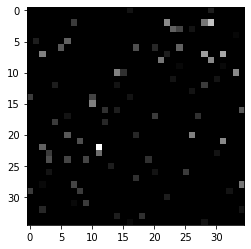

In [6]:
plt.imshow(distance_matrix,'gray')

In [7]:
distance_graph = nx.DiGraph(distance_matrix)

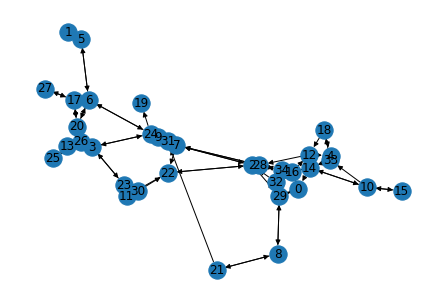

In [15]:
nx.draw_kamada_kawai(distance_graph,labels = lab_dict,with_labels=True)

In [63]:
dis_dic = nx.get_edge_attributes(distance_graph,'weight')

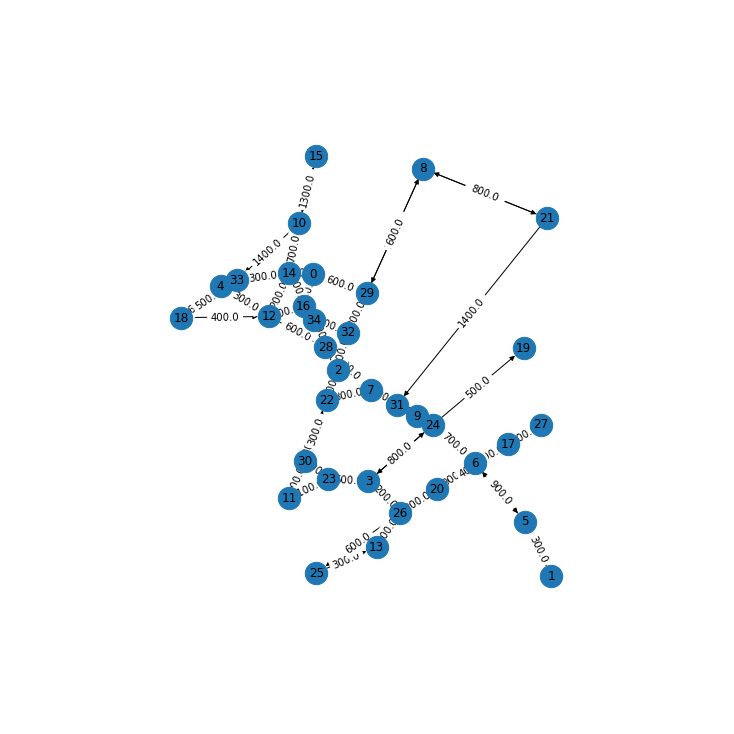

In [64]:
plt.figure(figsize=(10,10))

nx.draw(distance_graph,pos_graph,
            node_size=500,
            labels=lab_dict, 
            with_labels = True)

nx.draw_networkx_edge_labels(distance_graph,pos_graph,edge_labels=dis_dic)

plt.show()

## Grafo de capacidad

In [40]:
data_point = pd.read_csv('centros_googleApi')

In [41]:
centros = list(data_point['cluster_point'])

In [52]:
graph = nx.DiGraph()
pos_graph = []
lab_dict = {}
for i,centro in enumerate(centros):
    graph.add_node(i)
    lab_dict[i] = str(i)
    pos = centro.replace('(','').replace(')','').split(',')
    pos_graph.append((float(pos[0]),float(pos[1])))

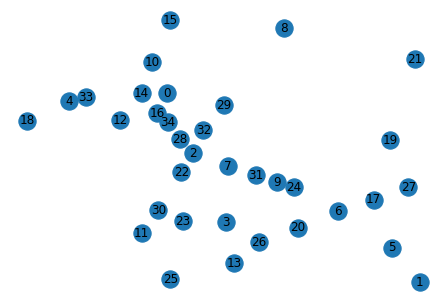

In [53]:
nx.draw(graph,pos_graph,labels=lab_dict,
       with_labels=True)

In [54]:
for edge in distance_graph.edges:
    capacity = distance_graph.edges[edge]['weight']//longitud
    graph.add_edge(edge[0],edge[1],capacity=int(capacity))

In [55]:
graph.edges[(0,16)]

{'capacity': 40}

In [56]:
distance_graph.edges[(0,16)]

{'weight': 200.0}

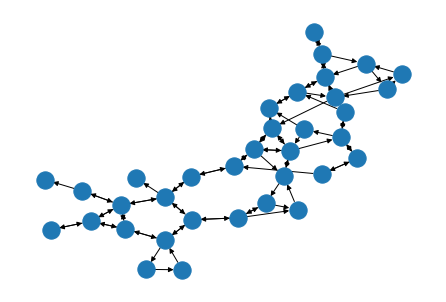

In [57]:
nx.draw_kamada_kawai(graph)

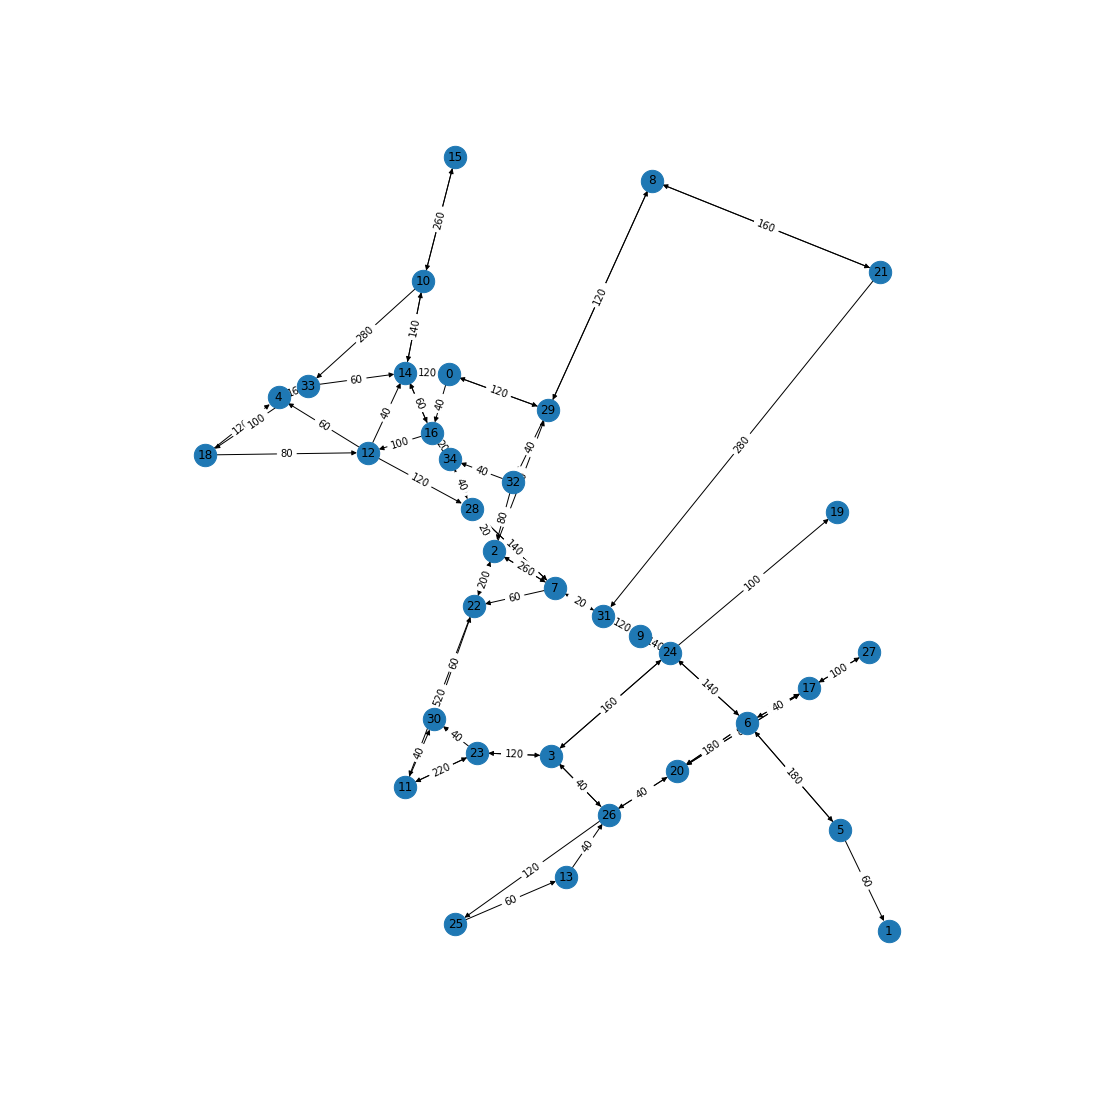

In [59]:
plt.figure(figsize=(15,15))
dis_dic = nx.get_edge_attributes(graph,'capacity')

nx.draw(graph,pos_graph,
            node_size=500,
            labels=lab_dict, 
            with_labels = True)

nx.draw_networkx_edge_labels(graph,pos_graph,edge_labels=dis_dic)

plt.show()

In [60]:
nx.maximum_flow(graph,15,11)

(220,
 {0: {16: 40, 29: 60},
  1: {},
  2: {7: 0, 22: 160, 28: 0, 29: 0},
  3: {23: 0, 24: 0, 26: 0},
  4: {33: 0},
  5: {1: 0, 6: 0},
  6: {5: 0, 17: 0, 20: 0, 24: 0},
  7: {2: 100, 22: 60, 28: 0, 31: 0},
  8: {21: 20, 29: 0},
  9: {24: 0, 31: 0},
  10: {14: 140, 15: 0, 33: 80},
  11: {23: 0, 30: 0},
  12: {4: 0, 14: 0, 28: 120},
  13: {26: 0},
  14: {0: 100, 10: 0, 16: 40},
  15: {10: 220},
  16: {12: 40, 14: 0, 34: 40},
  17: {6: 0, 20: 0, 27: 0},
  18: {4: 0, 12: 80},
  19: {},
  20: {6: 0, 17: 0, 26: 0},
  21: {8: 0, 31: 20},
  22: {2: 0, 11: 220},
  23: {3: 0, 11: 0, 30: 0},
  24: {3: 0, 6: 0, 9: 0, 19: 0},
  25: {13: 0},
  26: {3: 0, 20: 0, 25: 0},
  27: {17: 0},
  28: {2: 20, 7: 140, 34: 0},
  29: {0: 0, 8: 20, 32: 40},
  30: {22: 0},
  31: {7: 20, 9: 0},
  32: {2: 40, 34: 0},
  33: {14: 0, 18: 80},
  34: {16: 0, 28: 40}})

In [61]:
graph.edges[(15,10)]

{'capacity': 260}